<a href="https://colab.research.google.com/github/NigelGoh16/Sentiment_Analytics/blob/master/Sentiment_Analysis_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Procurement

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kazanova/sentiment140

 80% 65.0M/80.9M [00:00<00:00, 147MB/s]
100% 80.9M/80.9M [00:00<00:00, 147MB/s]


In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-11-01 15:45:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-01 15:45:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.11MB/s    in 2m 40s  

2023-11-01 15:48:34 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/sentiment140.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/glove.6B.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, LSTM, Activation, Dropout, Dense, Conv1D
from sklearn.model_selection import train_test_split

In [ ]:
# Dataset

# movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")

columns = ["sentiment","1","2","3","4","review"]
movie_reviews = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", names=columns)

In [ ]:
#Dataset exploration

movie_reviews.shape

(1600000, 6)

In [ ]:
#Dataset exploration

movie_reviews.head(5)

,sentiment,1,2,3,4,review
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#Missing value check

movie_reviews.isnull().values.any()

False

In [ ]:
movie_reviews['sentiment'] = movie_reviews['sentiment'].replace(4, 1)

In [ ]:
import plotly.express as px

vc = movie_reviews['sentiment'].value_counts()
print(vc)
for i in vc:
  print(i)

0    800000
1    800000
Name: sentiment, dtype: int64
800000
800000


In [ ]:
fig_bar = px.bar (movie_reviews, x=movie_reviews['sentiment'].unique().tolist(), y=vc.tolist())
fig_bar

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

stopwords_list = stopwords.words('english')

def preprocess_text(sen):
    sen = sen.lower()
    # Remove html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenized_list(df, column):
    df['tokenized'] = df[column].apply(preprocess_text)
    tokens = [token for sentence in df['tokenized'] for token in sentence.split()]
    return tokens

In [ ]:
tokens = tokenized_list(movie_reviews, "review")

<Axes: xlabel='sentiment', ylabel='count'>

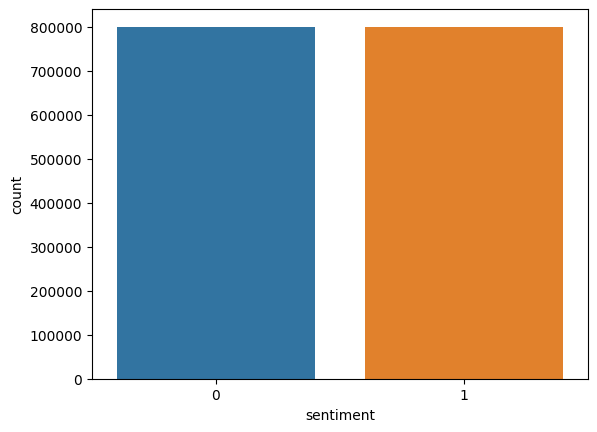

In [ ]:
#Positive/Negative distribution plot

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

Average length of sentence: 13.176150625 
Sentence length that encompasses 95%: 25


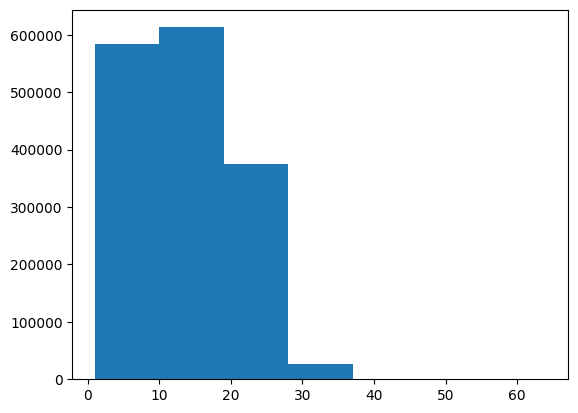

In [ ]:
# How long is each sentence on average?
total_sentences = movie_reviews['review'].to_list()
sent_lens = [len(sentence.split()) for sentence in total_sentences]
avg_sent_len = np.mean(sent_lens)
output_seq_len = int(np.percentile(sent_lens, 95))
print(f"Average length of sentence: {avg_sent_len} \nSentence length that encompasses 95%: {output_seq_len}" )
max_len = output_seq_len

# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

# Callbacks

In [ ]:
import os

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

# Data Preprocessing

In [ ]:
#Review example

movie_reviews["review"][2]

'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

In [ ]:
#tag removal
#Removes HTML tags: replace the anything between opening and closing <> with ''.

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(sen):
    sen = sen.lower()

    # Remove html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[2]

' kenichan dived many times ball managed save rest go bounds'

In [ ]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

# y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
y = np.array(list(y))
y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Tokenizing & Embeddings

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

507703

In [ ]:
import pickle

# saving
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=max_len)

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Visualize the shapes of values in the dictionary
# for key, value in embeddings_dictionary.items():
#     if isinstance(value, np.ndarray):
#         print(f'Key: {key}, Shape: {value.shape}')
#     else:
#         print(f'Key: {key}, Not a NumPy array')

In [ ]:
embedding_matrix = zeros((vocab_length, 50))

In [ ]:
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_layer = Embedding(507703, 50, weights=[embedding_matrix], input_length=25, trainable=False)

test1 = movie_reviews["review"][2]
test2 = X[2]
test3 = word_tokenizer.texts_to_sequences([test2])
test4 = pad_sequences(test3, padding='post', truncating='post', maxlen=max_len)
test5 = embedding_layer(test4)
print(f"Original test: {test1}\n{len(test1)} \
      \n\nPreprocessed text: {test2}\n{len(test2)} \
      \n\nTokenized Vectors: {test3}\n{len(test3)} \
      \n\nEqual length (95%) Vectors: {test4}\n{test4.shape} \
      \n\nEmbedded Vectors: {test5}\n{test5.shape}")

Original test: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
89       

Preprocessed text:  kenichan dived many times ball managed save rest go bounds
59       

Tokenized Vectors: [[30716, 94666, 208, 246, 1087, 1589, 779, 354, 5, 24571]]
1       

Equal length (95%) Vectors: [[30716 94666   208   246  1087  1589   779   354     5 24571     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]
(1, 25)       

Embedded Vectors: [[[ 0.        0.        0.       ...  0.        0.        0.      ]
  [-0.45581  -1.1128    1.0626   ... -0.34834   0.87854  -1.0101  ]
  [ 0.6979    0.08234   0.041526 ...  0.037265 -0.60443  -0.64699 ]
  ...
  [ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.        0.       ...  0.        0.        0.      ]]]
(1, 25, 50)


# Model 1 (SVM)

## Training

In [ ]:
# Neural Network architecture
from tensorflow.keras import layers
import numpy as np

tf.random.set_seed(42)
embedding_layer = Embedding(507703, 50, weights=[embedding_matrix], input_length=25 , trainable=False)

inputs = layers.Input(shape=(25,), dtype="int32")
x = embedding_layer(inputs)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM")

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model_1.summary()

Model: "model_1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 25, 50)            25385150  
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 25476927 (97.19 MB)
Trainable params: 91777 (358.50 KB)
Non-trainable params: 25385150 (96.84 MB)
_________________________________________________________________


In [ ]:
# Fit model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.15 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=20,
                              validation_data=valid_dataset,
                              validation_steps=int(0.15 * len(valid_dataset)),
                              callbacks=[early_stopping,
                                         reduce_lr,
                                         create_model_checkpoint(model_name="LSTM_GL_1L"),
                                         create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                     experiment_name="LSTM_GL_1L")])

Saving TensorBoard log files to: tensorflow_hub/LSTM_GL_1L/20231101-155221
Epoch 1/20
6000/6000 [==============================] - 49s 7ms/step - loss: 0.5635 - acc: 0.7066 - val_loss: 0.5310 - val_acc: 0.7344 - lr: 0.0010
Epoch 2/20
6000/6000 [==============================] - 46s 8ms/step - loss: 0.5211 - acc: 0.7396 - val_loss: 0.5080 - val_acc: 0.7477 - lr: 0.0010
Epoch 3/20
6000/6000 [==============================] - 53s 9ms/step - loss: 0.5056 - acc: 0.7499 - val_loss: 0.5067 - val_acc: 0.7552 - lr: 0.0010
Epoch 4/20
6000/6000 [==============================] - 45s 7ms/step - loss: 0.4943 - acc: 0.7579 - val_loss: 0.4866 - val_acc: 0.7629 - lr: 0.0010
Epoch 5/20
6000/6000 [==============================] - 54s 9ms/step - loss: 0.4874 - acc: 0.7627 - val_loss: 0.4783 - val_acc: 0.7689 - lr: 0.0010
Epoch 6/20
6000/6000 [==============================] - 39s 6ms/step - loss: 0.4806 - acc: 0.7674 - val_loss: 0.4815 - val_acc: 0.7699 - lr: 0.0010
Epoch 7/20
3994/6000 [===============

6000/6000 [==============================] - 38s 6ms/step - loss: 0.4819 - acc: 0.7658 - val_loss: 0.4745 - val_acc: 0.7723 - lr: 0.0010


## Evaluating & Visualizing

In [ ]:
score_1 = model_1.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 35s 4ms/step - loss: 0.4771 - acc: 0.7697


In [ ]:
tf.keras.saving.save_model(model_1, filepath='model_1.h5', save_format='h5')

<ipython-input-38-81b1abc1a981>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.saving.save_model(model_1, filepath='model_1.h5', save_format='h5')


In [ ]:
model_temp = tf.saved_model.load('model_experiments/LSTM_GL_1L')

In [ ]:
score_2 = model_temp(X_test)

# Model 2 (DNN)

## Training

## Evaluating & Visualizing

# Model 3 (LSTM)

## Training

## Evaluating & Visualizing

# Model 4 (GRU)

## Training

## Evaluating & Visualizing

# Model 5 (BiLSTM)

## Training

## Evaluating & Visualizing

# Model 6 (LSTM-GRU)

## Training

## Evaluating & Visualizing

# Model 7 (LSTM-CNN)

## Training

## Evaluating & Visualizing

# Model 8 (BiLSTM-CNN)

## Training

## Evaluating & Visualizing

# Model 9 (BiGru-CNN)

## Training

## Evaluating & Visualizing

In [ ]:
Model 10 ()

# File Download

In [ ]:
# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("tokenizer.pkl")
  # files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("model_1.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Syntax
# !wget -P /content/drive/My\ Drive [file URL]

!wget -P /content/drive/AI\ Drive '...'

In [ ]:
import shutil
import os

# Define the source folder (inside your Colab environment)
source_folder = '/content/model_experiments'

# Define the destination folder (inside your Google Drive)
destination_folder = '/content/drive/MyDrive/AI'

# Remove the destination folder (if it exists)
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

# Copy the source folder and its contents to the destination
shutil.copytree(source_folder, destination_folder)

'/content/drive/MyDrive/AI'